In [1]:
import os
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage.morphology import skeletonize
from PIL import Image
from scipy.stats import skew
from matplotlib.patches import Rectangle

To Remove?

In [2]:
def someOperationOnCol(image):
    anImage = image
    imageColumnWhiteCounterList = list()
    height, width = anImage.shape
    
    for col in range(width):
        whiteLengthCounter = 0
        for row in range(height):
            pixelValue = anImage[row, col]
            if (pixelValue == 1):
                whiteLengthCounter += 1
        imageColumnWhiteCounterList.append(whiteLengthCounter)

    averageWhiteCountThroughColumns = sum(imageColumnWhiteCounterList)/len(imageColumnWhiteCounterList)

    for index, colWhiteCount in enumerate(imageColumnWhiteCounterList):
        if colWhiteCount < averageWhiteCountThroughColumns:
            anImage[:,index] = 0
    return anImage

def someOperationOnRow(image):
    anImage = image
    imageColumnWhiteCounterList = list()
    height, width = anImage.shape
    for row in range(height):
        whiteLengthCounter = 0
        for col in range(width):
            pixelValue = anImage[row, col]
            if (pixelValue == 1):
                whiteLengthCounter += 1
        imageColumnWhiteCounterList.append(whiteLengthCounter)
    
    averageWhiteCountThroughColumns = sum(imageColumnWhiteCounterList)/len(imageColumnWhiteCounterList)

    for index, colWhiteCount in enumerate(imageColumnWhiteCounterList):
        if colWhiteCount < averageWhiteCountThroughColumns:
            anImage[index, :] = 0
    return anImage


Functions

In [3]:

def nanoImagePreprocessing(image, threshold, plot):
    grayImage = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    grayThresholdedImage = (grayImage < threshold).astype(float)

    if plot:
        fig, axs = plt.subplots(1, 3, figsize = (12,6))
        axs[0].imshow(image, cmap = "gray")
        axs[0].set_title("Original Image")
        axs[0].axis("off")

        axs[1].imshow(grayImage, cmap = "gray")
        axs[1].set_title("Gray Image")
        axs[1].axis("off")

        axs[2].imshow(grayThresholdedImage, cmap = "gray")
        axs[2].set_title("Gray Thresholded Image")
        axs[2].axis("off")
        plt.show()
    return grayThresholdedImage


def contourExtractor(thresholdedImage):

    if np.max(thresholdedImage) == 1:
        # Load your binary image (0 or 1 values)
        binaryImage = thresholdedImage.astype(np.uint8) * 255
    else:
        binaryImage = thresholdedImage

    skeleton = skeletonize(binaryImage)
    skeleton = 1-skeleton
    
    if np.max(skeleton) == 1:
        skeleton255 = skeleton.astype(np.uint8)
    else:
        skeleton255 = skeleton

    # Calculate the distance transform
    distTransform = cv2.distanceTransform(skeleton255, cv2.DIST_L2, cv2.DIST_MASK_PRECISE)
    logNormalizedDist = np.log((1e-9 + distTransform))  # Adding a small constant to avoid log(0)
    invLogNormalizedDist = 1 / logNormalizedDist
    clippedDist = np.where(invLogNormalizedDist <= 0, 0, invLogNormalizedDist)

    # Apply a colormap to the logarithmic distance values
    colorMap = cv2.applyColorMap(((clippedDist) * 255).astype(np.uint8), cv2.COLORMAP_MAGMA)

    return colorMap, skeleton255


def getPixelNumberForScale(thresholdedImage, isBorderBlack, printInfo, plotRuler):
    # Load the binary image (white pixels on a black background)
    if np.max(thresholdedImage) == 1:
        binaryImage = thresholdedImage * 255

    # Initialize variables to keep track of the longest run
    longestWhiteRunLength = 0
    longest_run_start = 0
    longest_run_end = 0
    longest_run_row = 0

    # Iterate through each row in the binary image
    current_run_length = 0
    current_run_start = 0
    current_run_end = 0

    if isBorderBlack:
        runCheckColorValue = 255
    else:
        runCheckColorValue = 0

    for row in range(binaryImage.shape[0]):
        inRun = False  # Flag to track if we are in a white pixel run
        for col in range(binaryImage.shape[1]):
            pixelValue = binaryImage[row, col]    

            if int(pixelValue) == runCheckColorValue:  # Check for a white pixel (255 in grayscale)
                if not inRun:
                    current_run_length = 0
                    current_run_start = col
                    inRun = True
                current_run_length += 1
                current_run_end = col

            else:
                if current_run_length >= longestWhiteRunLength:
                    longestWhiteRunLength = current_run_length
                    longest_run_start = current_run_start
                    longest_run_end = current_run_end
                    longest_run_row = row
                inRun = False
                current_run_length = 0

    if printInfo:
        print("Longest White Pixel Run:")
        print("Start Column:", longest_run_start)
        print("End Column:", longest_run_end)
        print("Length:", longestWhiteRunLength)
        print("Row index:", longest_run_row)

    if plotRuler:
        # Create a copy of the binary image
        highlightedImage = binaryImage.copy()

        highlightedImage[:, :longest_run_start] = 0
        highlightedImage[:, longest_run_end + 1:] = 0
        highlightedImage[:longest_run_row, :] = 0
        highlightedImage[longest_run_row + 1:, :] = 0
        plt.imshow(highlightedImage, cmap="gray")
        plt.show()

    return longestWhiteRunLength

/var/folders/xg/gt2nprs91yd_39t6sdd24t4w0000gn/T/ipykernel_991/4227813170.py:41: RuntimeWarning: divide by zero encountered in divide
  invLogNormalizedDist = 1 / logNormalizedDist
/var/folders/xg/gt2nprs91yd_39t6sdd24t4w0000gn/T/ipykernel_991/4227813170.py:45: RuntimeWarning: invalid value encountered in cast
  colorMap = cv2.applyColorMap(((clippedDist) * 255).astype(np.uint8), cv2.COLORMAP_MAGMA)


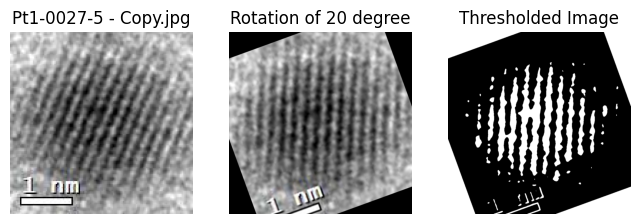

In [24]:
grayThreshold = 80 #user input
nanoResolution = 1 # user input, in nm
magniFactor = 7  # Define the factor by which you want to magnify the image
rotationAngle = 20  # Change this to the desired rotation angle


imageNamesList = os.listdir("IMAGES/")
imageFolderPath= "IMAGES/"
imageName = imageNamesList[6]
imagePath = os.path.join(imageFolderPath, imageName)
originalImage = Image.open(imagePath)
width, height = originalImage.size

# Calculate the new dimensions
magnifWidth = width * magniFactor
magnifHeight = height * magniFactor
# Resize the image
magnifiedImage = originalImage.resize((magnifWidth, magnifHeight)) # Magnified Image
magnifiedImageName = f"{imageName}_magnified.jpg"
# Save the magnified image
magnifiedImage.save(magnifiedImageName)

magnifiedImage = plt.imread(magnifiedImageName)
thresholdedImageForRuler = nanoImagePreprocessing(magnifiedImage, grayThreshold, False)
longestWhiteRunLength = getPixelNumberForScale(thresholdedImageForRuler, True, False, False)

# Calculate the rotation matrix
rotationMatrix = cv2.getRotationMatrix2D((magnifWidth / 2, magnifHeight / 2), rotationAngle, 1)
rotatedImage = cv2.warpAffine(magnifiedImage, rotationMatrix, (magnifWidth, magnifHeight))

binaryThresholdedImage = nanoImagePreprocessing(rotatedImage, grayThreshold, False)
colorMap, skeleton = contourExtractor(binaryThresholdedImage)

fig, axs = plt.subplots(1, 3, figsize = (8,4))
axs[0].imshow(originalImage, cmap = "gray")
axs[0].set_title(f"{imageName}")
axs[0].axis("off")

axs[1].imshow(rotatedImage, cmap = "gray")
axs[1].set_title(f"Rotation of {rotationAngle} degree")
axs[1].axis("off")

axs[2].imshow(binaryThresholdedImage, cmap = "gray")
axs[2].set_title("Thresholded Image")
axs[2].axis("off")
plt.show()

Chosen stride:  215
Chosen kernel size:  358.40000000000003


/var/folders/xg/gt2nprs91yd_39t6sdd24t4w0000gn/T/ipykernel_991/4208867412.py:18: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skewValue = skew(piece)
/var/folders/xg/gt2nprs91yd_39t6sdd24t4w0000gn/T/ipykernel_991/4208867412.py:29: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skewValue = skew(piece)


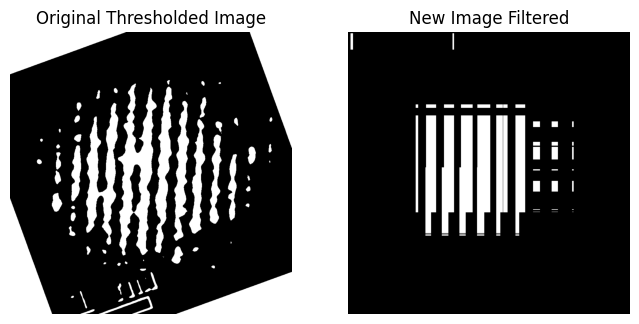

In [25]:

def maskExtractorOneDim(thresholdedImage, averageBinaryThreshold, kernelSize, stride, onCol):
    newImageToFillT = np.zeros((thresholdedImage.shape[0], thresholdedImage.shape[1]))

    if onCol:
        thresholdedImage = thresholdedImage.T
        newImageToFillT = newImageToFillT.T

    for rowIndex, row in enumerate(thresholdedImage):
        outputLength = int(((row.shape[0] - kernelSize) // stride) + 1)

        meanResult = np.zeros(outputLength)
        skewResult = np.zeros(outputLength)

        for index in range(outputLength):
            piece = row[int(index * stride): int(index * stride + kernelSize)]

            average = np.mean(piece)
            skewValue = skew(piece)
            
            meanResult[index] = average
            skewResult[index] = skewValue

        meanOfMean = np.mean(meanResult)
        meanOfSkew = np.mean(skewResult)

        for index in range(outputLength):
            piece = row[int(index * stride): int(index * stride + kernelSize)]
            average = np.mean(piece)
            skewValue = skew(piece)

            if ((average > meanOfMean) & (average > averageBinaryThreshold) & (skewValue < meanOfSkew)):
                pieceIndexOne = range(int(index * stride), int(index * stride + kernelSize))
                newImageToFillT[rowIndex, pieceIndexOne] = 1

    return newImageToFillT
    
def statisticalOperation(thresholdedImage, kernelSize, stride):
    print("Chosen stride: ",stride)
    print("Chosen kernel size: ", kernelSize)

    newImageToFillRow = maskExtractorOneDim(thresholdedImage, 0.3, kernelSize, stride, False)
    newImageToFillCol = maskExtractorOneDim(thresholdedImage, 0.3, kernelSize, stride, True)
    
    newImageToFillCol = newImageToFillCol.T
    newImageFilled = np.multiply(newImageToFillRow, newImageToFillCol)
    
    fig, axs = plt.subplots(1, 2, figsize = (8,4))
    axs[0].imshow(thresholdedImage, cmap = "gray")
    axs[0].set_title("Original Thresholded Image")
    axs[0].axis("off")
    axs[1].imshow(newImageFilled, cmap = "gray")
    axs[1].set_title("New Image Filtered")
    axs[1].axis("off")
    
    plt.show()
    
    return newImageFilled


kernelSize = binaryThresholdedImage.shape[0] * 0.4 # user input
stride = int(kernelSize*0.6) # user input
newImageFilled = statisticalOperation(binaryThresholdedImage, kernelSize, stride)



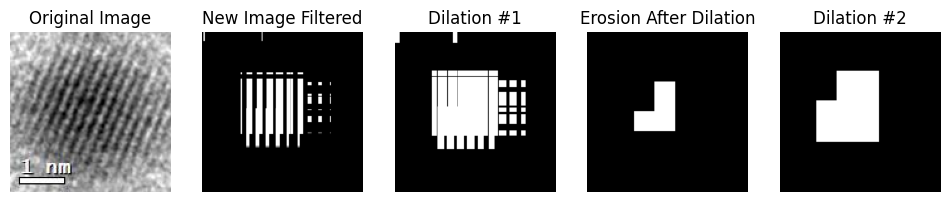

In [26]:
dilationOneKernelSize = 21 #user input
erosionKernelSize = 53 #user input
dilationTwoKernelSize = 121 #user input

kernelDilation = np.ones((dilationOneKernelSize, dilationOneKernelSize), np.uint8)
kernelErosion = np.ones((erosionKernelSize, erosionKernelSize), np.uint8)
kernelDilation2 = np.ones((dilationTwoKernelSize, dilationTwoKernelSize), np.uint8)


dilatedImage1 = cv2.dilate(newImageFilled, kernelDilation, iterations=1) 
erodedImage = cv2.erode(dilatedImage1, kernelErosion, iterations=1) 
dilatedImage2 = cv2.dilate(erodedImage, kernelDilation2, iterations=1) 

fig, axs = plt.subplots(1, 5, figsize = (12,6))


axs[0].imshow(originalImage, cmap = "gray")
axs[0].set_title("Original Image")
axs[0].axis("off")

axs[1].imshow(newImageFilled, cmap = "gray")
axs[1].set_title("New Image Filtered")
axs[1].axis("off")

axs[2].imshow(dilatedImage1, cmap = "gray")
axs[2].set_title("Dilation #1")
axs[2].axis("off")

axs[3].imshow(erodedImage, cmap = "gray")
axs[3].set_title("Erosion After Dilation")
axs[3].axis("off")

axs[4].imshow(dilatedImage2, cmap = "gray")
axs[4].set_title("Dilation #2")
axs[4].axis("off")



plt.show()

/var/folders/xg/gt2nprs91yd_39t6sdd24t4w0000gn/T/ipykernel_991/4227813170.py:41: RuntimeWarning: divide by zero encountered in divide
  invLogNormalizedDist = 1 / logNormalizedDist
/var/folders/xg/gt2nprs91yd_39t6sdd24t4w0000gn/T/ipykernel_991/4227813170.py:45: RuntimeWarning: invalid value encountered in cast
  colorMap = cv2.applyColorMap(((clippedDist) * 255).astype(np.uint8), cv2.COLORMAP_MAGMA)


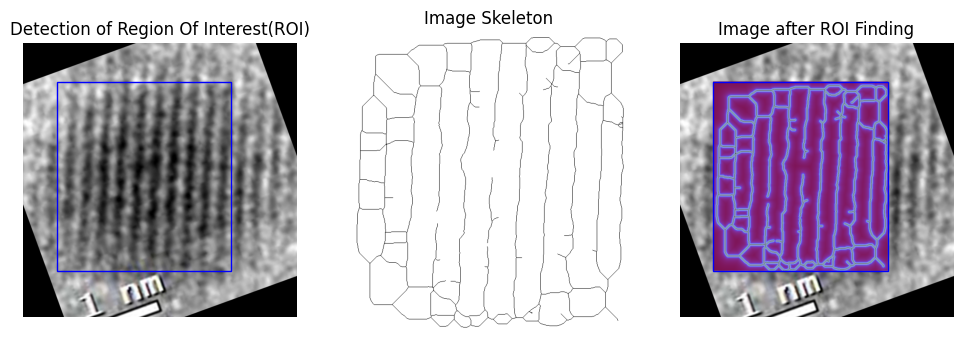

In [27]:
rotatedImageCopy = np.array(rotatedImage)

binaryComponentsIm = dilatedImage2
whitePixels = binaryComponentsIm > 0 # Find the white pixels

# Find connected components and calculate center of mass
numLabels, labels, stats, centroids = cv2.connectedComponentsWithStats(whitePixels.astype(np.uint8))
areas = stats[1:, cv2.CC_STAT_WIDTH] * stats[1:, cv2.CC_STAT_HEIGHT]

if (areas.shape[0] != 1):
    sizeThreshold = np.median(areas)
    filteredShapes = [label for label, area in enumerate(areas, start=1) if area > sizeThreshold]
    scopeRange = filteredShapes
else:
    scopeRange = range(1, numLabels)

expansionWidth = np.sqrt(np.mean(areas)) * 0.30 #0.09  # User input

# Iterate through each component found in the image
fig, axs = plt.subplots(1, 3, figsize = (12,6))

for label in scopeRange:   # Skip background (label 0)
    centerX, centerY = int(centroids[label][0]), int(centroids[label][1])
    width = stats[label, cv2.CC_STAT_WIDTH]
    height = stats[label, cv2.CC_STAT_HEIGHT]

    # Calculate the new bounding box coordinates
    x = max(centerX - (width // 2 + expansionWidth), 0)
    y = max(centerY - (height // 2 + expansionWidth), 0)

    newWidth = min(width + 2 * expansionWidth, binaryComponentsIm.shape[1] - x)
    newHeight = min(height + 2 * expansionWidth, binaryComponentsIm.shape[0] - y)

    # Extract the bounded region from the original image
    startY = int(y)
    endY = int(y+newHeight)
    startX = int(x)
    endX = int(x+newWidth)

    boundedRegion = binaryThresholdedImage[int(startY): int(endY), int(startX) : int(endX)]
    boundedRegion = 1 - boundedRegion
    colorMap, skeleton255 = contourExtractor(boundedRegion) #.astype(np.uint8) * 255
    rotatedImageCopy[int(startY): int(endY), int(startX): int(endX)] = colorMap
    rectangle = Rectangle((x, y), newWidth, newHeight, fill=False, edgecolor='blue', linewidth=1)

    axs[0].imshow(rotatedImage, cmap = "gray")
    axs[0].add_patch(rectangle)
    plt.imshow(rotatedImage, cmap= "gray")
    plt.gca().add_patch(plt.Rectangle((x, y), newWidth, newHeight, fill=False, edgecolor='blue', linewidth=1))

# Display the resulting image with rectangles
axs[0].axis('off')
axs[0].set_title("Detection of Region Of Interest(ROI)")

axs[1].imshow(skeleton255, cmap = "gray")
axs[1].set_title("Image Skeleton")
axs[1].axis("off")

axs[2].imshow(rotatedImageCopy, cmap = "gray")
axs[2].set_title("Image after ROI Finding")
axs[2].axis("off")
plt.show()

In [28]:
def distanceColorMapper(distance, distanceBaseinNm, longestWhiteRunLength, nanoResolution):
    distancePerPixel = nanoResolution / longestWhiteRunLength  #in nm
    distanceBase = int(distanceBaseinNm / distancePerPixel) # how many pixels
    signedPercentage = ((distance - distanceBase) / distanceBase)

    if (distance > distanceBase):
        pixelIntensity = np.clip((255 * (signedPercentage ** 0.3)), 0, 255)
        color = (255 - int(pixelIntensity), 0, 0)

    elif (distance < distanceBase):
        percentage = signedPercentage * -1
        pixelIntensity = np.clip((255 * (percentage ** 0.3)), 0, 255)
        color = (0, int(pixelIntensity), 0)
    
    else:
        color = (0, 0, 255)
    return color, signedPercentage

In [29]:
distanceBaseinNm = 0.226 #in nm? user input
newImageWithColoring = skeleton255.copy()
newImageWithColoringRGB = cv2.cvtColor(newImageWithColoring,cv2.COLOR_GRAY2RGB)

distanceList = list()
percentageList = list()
colorList = list()

for rowIndex in range(skeleton255.shape[0]):
    oldPixel = 1
    distanceStartIndex = 0
    distanceEndIndex = 0
    for columnIndex in range(skeleton255.shape[1]):
        pixel = skeleton255[rowIndex][columnIndex]
        if ((oldPixel == 1) & (pixel == 0)):
            distanceEndIndex = columnIndex
            distance = distanceEndIndex - distanceStartIndex
            distanceList.append(distance)

            color, signedPercentage = distanceColorMapper(distance, distanceBaseinNm, longestWhiteRunLength, nanoResolution)
            newImageWithColoringRGB[rowIndex, distanceStartIndex: distanceEndIndex] = color
            
            percentageList.append(signedPercentage * 100)
            colorList.append(color)
        elif (oldPixel == 0) & (pixel == 1):
            distanceStartIndex = columnIndex - 1

        oldPixel = pixel


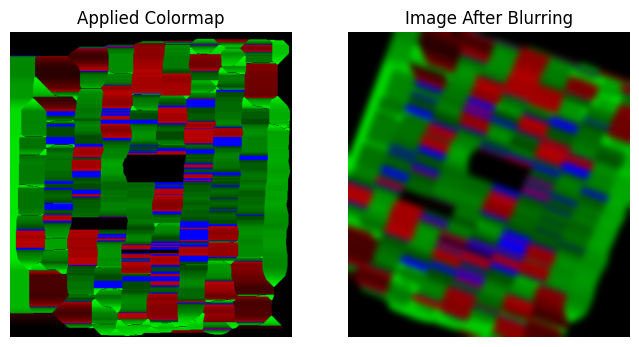

In [30]:
fig, axs = plt.subplots(1, 2, figsize = (8,6))
fig.subplots_adjust(bottom=0.2)

axs[0].imshow(newImageWithColoringRGB, cmap = "gray")
axs[0].set_title("Applied Colormap")
axs[0].axis("off")


angle = -rotationAngle
# Get the dimensions of the image
height, width = newImageWithColoringRGB.shape[:2]
# Calculate the rotation matrix
rotationMatrix = cv2.getRotationMatrix2D((width / 2, height / 2), angle, 1)
# Perform the rotation
rotatedReverseImage = cv2.warpAffine(newImageWithColoringRGB, rotationMatrix, (width, height))

kSize = (43,43) 
blurredImage = cv2.GaussianBlur(rotatedReverseImage, kSize, 0)

axs[1].imshow(blurredImage, cmap = "gray")
axs[1].set_title(f"Image After Blurring")
axs[1].axis("off")

plt.show()

Statistical Distribution

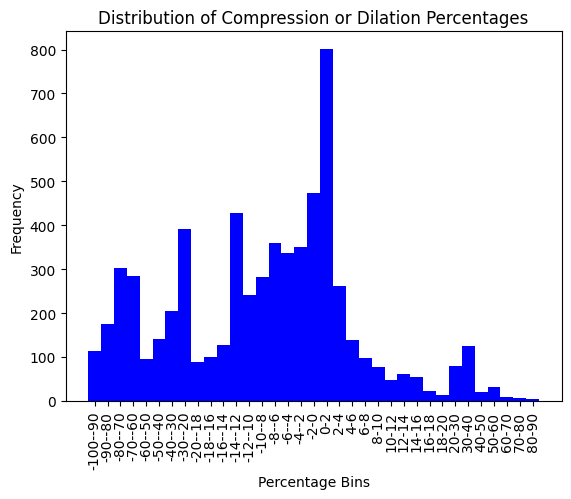

In [31]:
# Sample data (replace with your list of values)
data = percentageList

# Manually define the bin edges
binEdges2 = np.arange(-100, -20, 10)  # From -100 to -10 with a step of 20
binEdges1 = np.arange(-20, 20, 2)  # From -10 to 10 with a step of 2
binEdges3 = np.arange(20, 100, 10)  # From 10 to 100 with a step of 10

# Combine all bin edges into one list
binEdges = np.concatenate([binEdges2, binEdges1, binEdges3])

# Create a histogram based on the specified bin edges
hist, bins = np.histogram(data, bins = binEdges)

xLabels = [f'{binEdges[i]}-{binEdges[i+1]}' for i in range(len(binEdges) - 1)]

# Create a bar plot
plt.bar(range(len(hist)), hist, width=1, align='edge', color='b')
# Add labels and title
plt.xlabel('Percentage Bins')
plt.ylabel('Frequency')
plt.title('Distribution of Compression or Dilation Percentages')
# Customize x-axis labels
plt.xticks(np.arange(len(hist)) + 0.5, xLabels, rotation = 90)
# Create a DataFrame from the data

histogramDf = pd.DataFrame({'Bin Edges': binEdges[:-1], 'Frequency': hist})
histogramDf.to_excel(f'{imageName} histogram data.xlsx', index=False)

# Show the plot
plt.show()


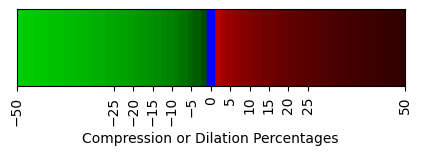

In [32]:
values = percentageList
rgbValues = colorList
normalizedColors = [(r / 255, g / 255, b / 255) for r, g, b in rgbValues]

plt.figure(figsize=(5,1))

for index, value in enumerate(values):
    plt.axvline(x=value, color= normalizedColors[index], linestyle='solid', linewidth = 6)
plt.xlabel("Compression or Dilation Percentages")
plt.xticks([-100, -75, -50, -25, -20, -15, -10, -5, 0, 5, 10, 15, 20, 25, 50, 75, 100], rotation = 90)
plt.yticks([])
plt.xlim(-50, 50)
plt.show()


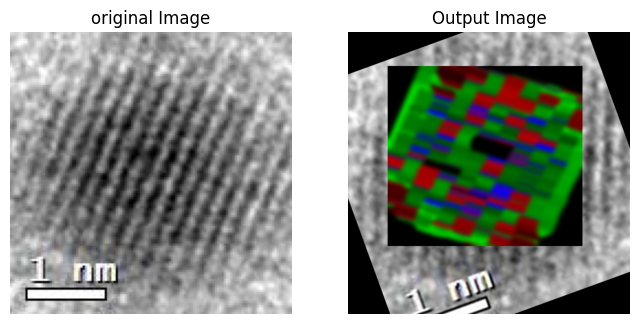

In [35]:

omg = np.array(rotatedImage)
blurred_image = cv2.resize(blurredImage, (endY - startY, endX - startX))
omg[startX: endX, startY : endY] = blurred_image

fig, axs = plt.subplots(1, 2, figsize = (8,4))
axs[0].imshow(originalImage, cmap = "gray")
axs[0].set_title("original Image")
axs[0].axis("off")


axs[1].imshow(omg, cmap = "gray")
axs[1].set_title("Output Image")
axs[1].axis("off")
plt.show()